# Null Imputation and Data Pre-processing

In [193]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import modelling as ml
from visualisations import compare_histograms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

# set random seed for reproducibility
np.random.seed(42)

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [194]:
df = pd.read_csv('../data/clean_combined_wines.csv')
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino,age
name,,,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,51,18,26,0,4,47,66.0,0.0,0,13.0,"JS, WE, WS",0,1992
00 Wines Vgr Pinot Noir 2019,51,18,29,0,1,131,82.0,0.0,0,12.9,"WE, JS, RP",0,1989
00 Wines Egw Chardonnay 2019,51,18,29,0,4,47,95.0,0.0,0,NaN,"JS, RP, WE",0,1989
100 Nails Ranch Pinot Noir 2019,95,18,29,1,1,131,14.0,0.0,0,14.2,WW,0,1989
100 Nails Ranch Chardonnay 2019,279,18,29,1,4,47,14.0,0.0,0,14.2,0,0,1989


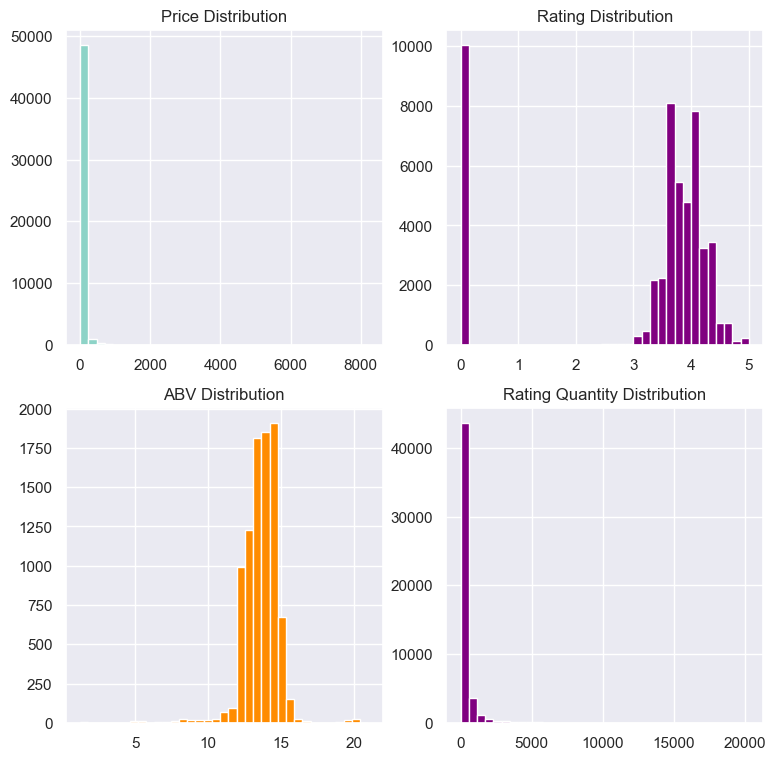

In [195]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))  # 4 subplots

# plot price
axs[0, 0].hist(df['price'], bins=35)
axs[0, 0].set_title('Price Distribution')
axs[0, 0].grid(True)

# plot rating
axs[0,1].hist(df['rating'], bins=35, color='Purple')
axs[0,1].set_title('Rating Distribution')  # Adjusted title and x label
axs[0,1].grid(True)

# plot rating_qty
axs[1, 1].hist(df['rating_qty'], bins=35, color='Purple')
axs[1, 1].set_title('Rating Quantity Distribution')  # Adjusted title and x label
axs[1, 1].grid(True)

# plot abv
axs[1, 0].hist(df['abv'], bins=35, color='DarkOrange')
axs[1, 0].set_title('ABV Distribution')  # Provided a title and x label
axs[1, 0].grid(True)

* Prices are heavily right skewed and would likely benefit from a logarithmic transformation before modelling.
* Rating qty also heavily right skewed and would likely benefit from a logarithmic transformation before modelling. Most wines have very few reviews, with some extreme outliers up to a max of 29389. 
* ABV content fairly normally distibuted with clear spike at median of 13.5% 

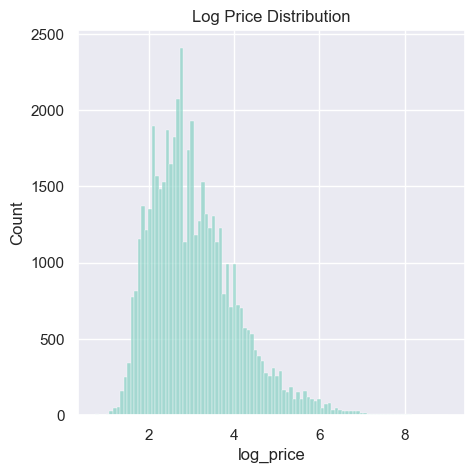

In [196]:
# remove price outliers from dataframe, log transform price and plot

df['log_price'] = np.log(df['price'])
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution')
sns.histplot(df['log_price'], bins=100)  # kde=False turns off the kernel density estimate plot overlay
plt.show();

* Log price much more normally distributed. 

Max outlier bound log_price: 5.597
Number of remaining rows: 48818, rows removed: 1157


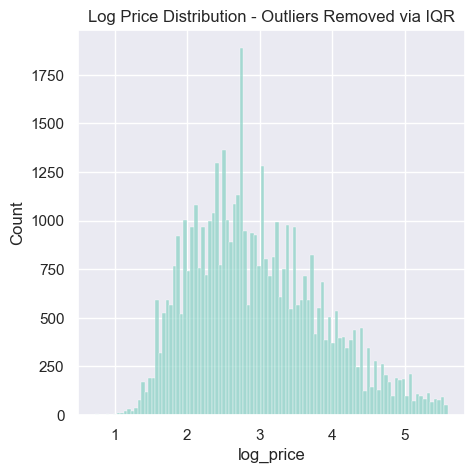

In [197]:
# calculate interquartile range of price, and set a limit at 1.5 IQR above 75% percentile
Qrt1 = np.quantile(df['log_price'], 0.25)
Qrt3 = np.quantile(df['log_price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
df_IQR_price = df[df['log_price'] < outlier_price_limit]
print('Max outlier bound log_price: ', round(outlier_price_limit,3), sep='')
print(f'Number of remaining rows: {df_IQR_price.shape[0]}, rows removed: {df.shape[0] - df_IQR_price.shape[0]}')
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution - Outliers Removed via IQR')
sns.histplot(df_IQR_price['log_price'], bins=100) 
plt.show();

In [198]:
df['log_price'].describe()

count    49975.000000
mean         3.049411
std          1.011513
min          0.732368
25%          2.302585
50%          2.885359
75%          3.620467
max          9.013717
Name: log_price, dtype: float64

* One of the data scrapes in our original data set had a cut off for minimum number of reviews. Hence the sharp drop in log rating_qty at around 3.5.

## Reduce Categories 

In [199]:
print('Prior Length:', df['region'].value_counts().shape[0])
region_value_counts = df['region'].value_counts()
remove_regions = region_value_counts[region_value_counts < 31]
df['region'] = df['region'].apply(lambda x: 'Unknown' if x in remove_regions.index else x)
print('Post Length:', df['region'].value_counts().shape[0])

Prior Length: 306
Post Length: 306


In [200]:
print('Prior Length:', df['country'].value_counts().shape[0])
region_value_counts = df['country'].value_counts()
remove_regions = region_value_counts[region_value_counts < 31]
df['country'] = df['country'].apply(lambda x: 'Unknown' if x in remove_regions.index else x)
print('Post Length:', df['country'].value_counts().shape[0])

Prior Length: 23
Post Length: 23


In [201]:
df['vintage'].value_counts()

vintage
25    8042
26    7859
27    7127
24    6113
29    3827
22    3497
30    3034
20    2423
31    1745
19    1630
18    1189
17     792
10     663
15     410
14     377
11     217
13     212
9      135
3      109
2       89
5       77
7       72
6       64
46      45
48      45
47      42
45      42
32      14
12      12
23      11
41      11
42      11
44      10
43       8
40       6
39       2
28       1
36       1
16       1
4        1
33       1
37       1
38       1
1        1
35       1
0        1
8        1
34       1
21       1
Name: count, dtype: int64

In [202]:
df['age'] = df['vintage'].apply(lambda x: 2024 - int(x))

# Zero Values and Null Imputation

### Imputing ABV

In [203]:
df.columns

Index(['region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety', 'price', 'rating', 'rating_qty', 'abv', 'reviewed_by',
       'from_vivino', 'age', 'log_price'],
      dtype='object')

In [204]:
print(f'Ratings zero values: {(df["rating"] == 0).sum()}')
print(f'Ratings_qty zero values: {(df["rating_qty"] == 0).sum()}')
print(f'ABV nulls: {(df["abv"].isna().sum())}')

Ratings zero values: 10051
Ratings_qty zero values: 10051
ABV nulls: 40966


In [205]:
# df_with_abv = df[df['abv'].isna() == False]
# find_rating_median = df_with_abv[df_with_abv['rating'] != np.nan]
# find_rating_qty_median = df_with_abv[df_with_abv['rating_qty'] != np.nan]

In [206]:
# # impute median for nulls in rating and rating_qty
# median_rating_df_with_abv = find_rating_median['rating'].median()
# median_rating_qty_df_with_abv = find_rating_qty_median['rating_qty'].median()
# df_with_abv.loc[df_with_abv['rating'].isna(), 'rating'] = median_rating_df_with_abv
# df_with_abv.loc[df_with_abv['rating_qty'].isna(), 'rating_qty'] = median_rating_qty_df_with_abv

**Manual ABV Regression Imputation**

In [207]:
# Drop columns that a priori wont be helpful for predicting abv: from_vivino, reviewed_by, name
# Or those that have over 500 different categories e.g. producer 
# to_be_encoded_abv = df_with_abv.drop(columns=['reviewed_by', 'price'])

In [208]:
# to_be_encoded_abv.columns

In [209]:
# df_encoded_impute_abv = pd.get_dummies(to_be_encoded_abv, columns=['region', 'country', 'vintage', 'wine_variety', 
#                                                                    'grape_variety', 'from_vivino'],  drop_first=True, dtype=int)

In [210]:
# X = df_encoded_impute_abv.drop(columns = ['abv', 'producer'])
# y = df_encoded_impute_abv['abv']

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.85)

In [211]:
# # find best model for imputing ABV 
# regression_model_selector

In [212]:
# # baseline predictioning mean performance RSME = 1.503
# predictions_baseline =[y_train.mean() for i in range(0,y_test.shape[0])]
# np.sqrt(mean_squared_error(y_test, predictions_baseline))

In [213]:
# # rsme of LR model performs better RSME = 0.5021
# predictions = lr_abv.predict(X_test)
# np.sqrt(mean_squared_error(y_test, predictions))

In [214]:
# rf_abv = RandomForestRegressor()
# rf_abv.fit(X_train, y_train)
# print(f"Train cv: {cross_val_score(rf_abv, X_train, y_train, cv = 5,scoring='r2').mean()}")

In [215]:
# # 0.750539353073274
# predictions_rf = rf_abv.predict(X_test)
# np.sqrt(mean_squared_error(y_test, predictions_rf))

## Iterative Imputer

**With all categories label encoded**

In [216]:
columns_to_encode = ['region', 'country', 'vintage', 'wine_variety', 'grape_variety', 'from_vivino', 'producer']

# Initialize a LabelEncoder
le = LabelEncoder()

# Loop over the columns and apply Label Encoding
for column in columns_to_encode:
    # The LabelEncoder expects a 1D array, so we use df[column]
    df[column] = le.fit_transform(df[column].astype(str))  # Ensure data type is string for encoding


In [217]:
#features_for_imputation = df[['abv']]
it_imp = IterativeImputer(estimator=LinearRegression(), 
                           max_iter=5)
imputed_data = it_imp.fit_transform(df.drop(columns = ['reviewed_by']))
imputed_data = pd.DataFrame(imputed_data, columns=df.drop(columns = ['reviewed_by']).columns)

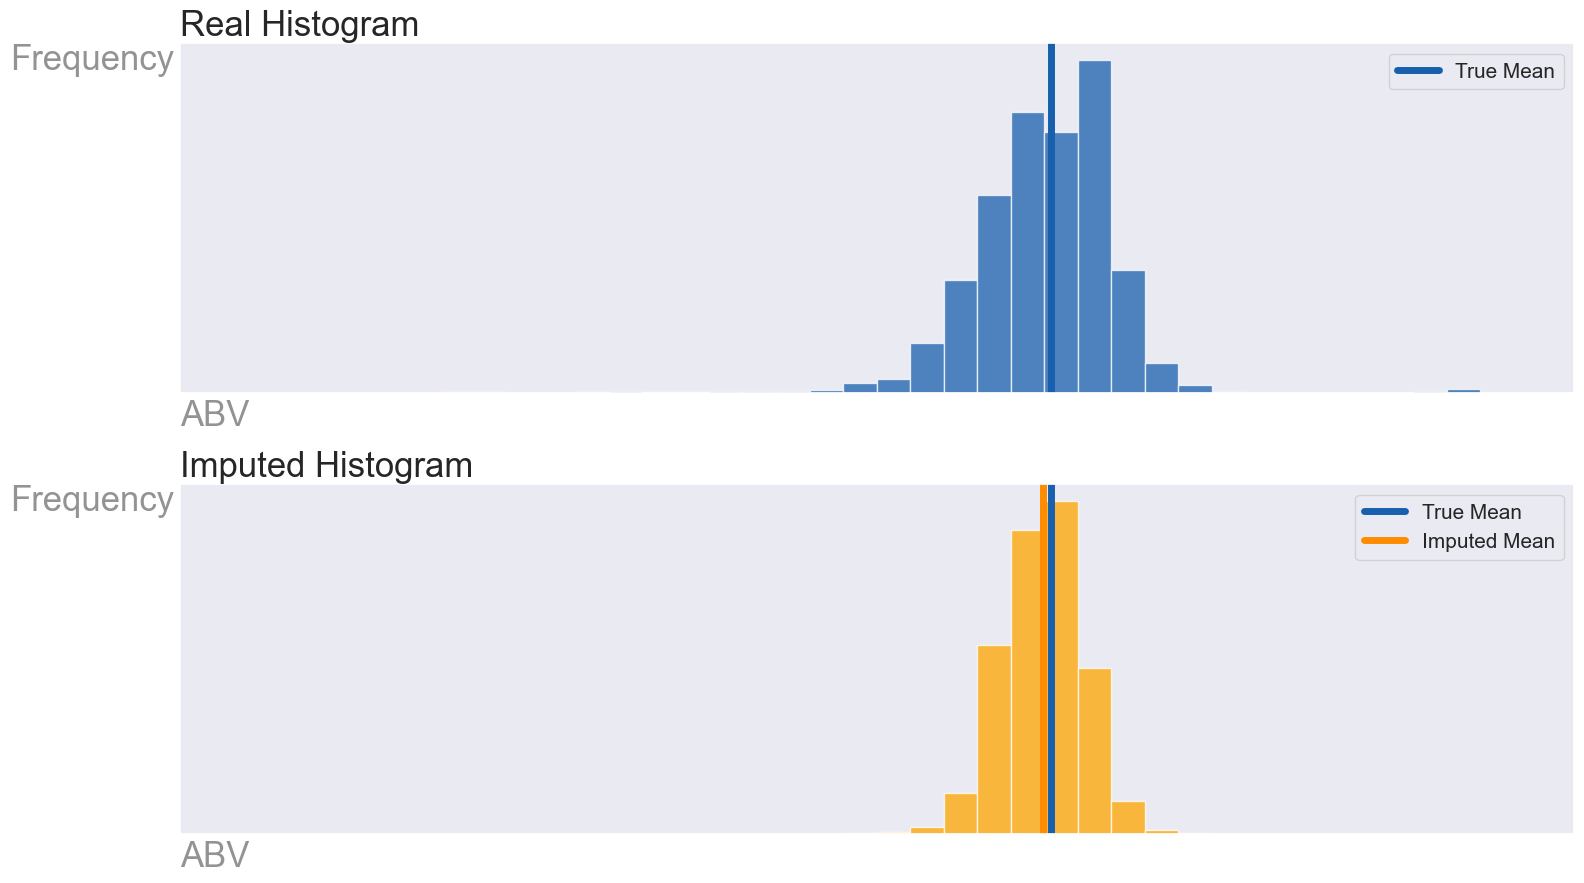

In [218]:
compare_histograms(imputed_column = imputed_data['abv'],
                   original_column = df['abv'],
                   x_label = 'ABV',
                   y_label = 'Frequency', bins = 40)

In [219]:
#features_for_imputation = df[['abv']]
it_imp_rf = IterativeImputer(estimator=DecisionTreeRegressor(), 
                           max_iter=5)
imputed_data_rf = it_imp_rf.fit_transform(df.drop(columns = ['reviewed_by']))
imputed_data_rf = pd.DataFrame(imputed_data_rf, columns=df.drop(columns = ['reviewed_by']).columns)

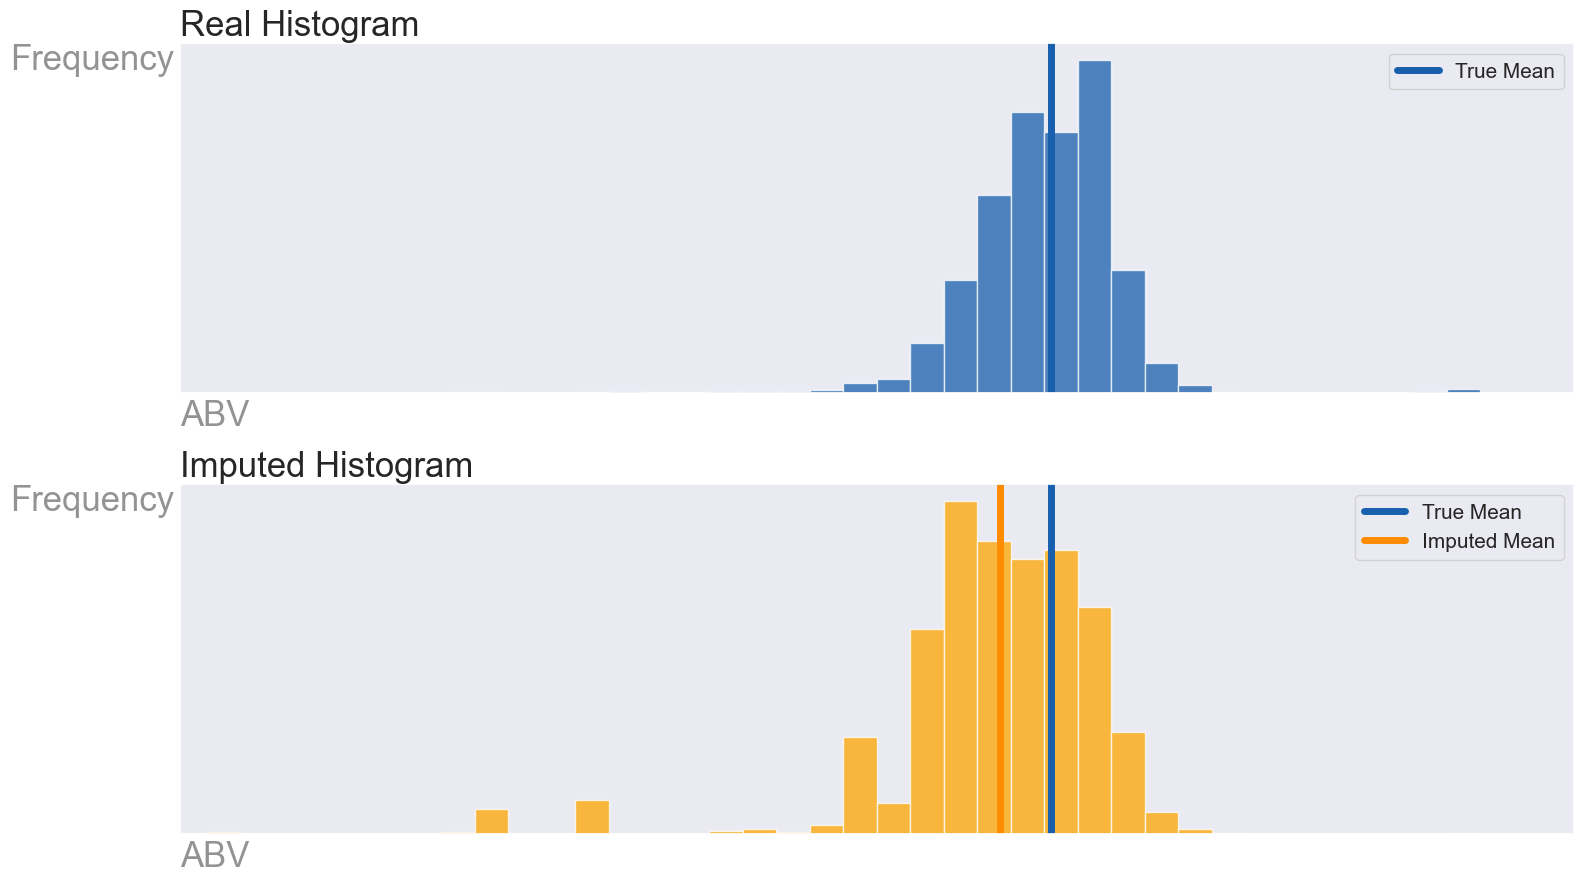

In [220]:
compare_histograms(imputed_column = imputed_data_rf['abv'],
                   original_column = df['abv'],
                   x_label = 'ABV',
                   y_label = 'Frequency', bins = 40)

The linear regression imputation is better at maintaining the mean of the distrbution and although it reduces the spread of the ABV distribution it matches the over all shape with less outliers than decision trees. 

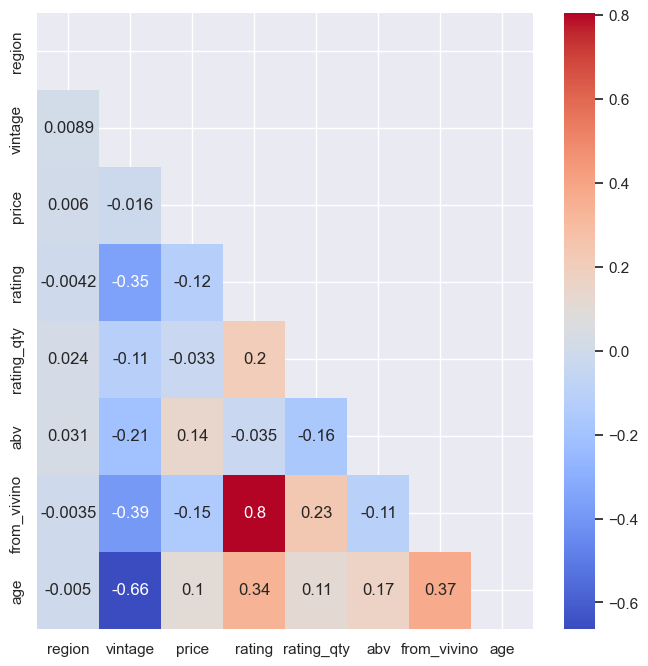

In [221]:
numeric = imputed_data.drop(columns = ['country', 'wine_variety', 'grape_variety', 'producer', 'log_price'])

plt.figure(figsize=(8, 8))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='coolwarm');

In [222]:
imputed_data.set_index(df.index, inplace=True)
imputed_data.to_csv('../data/modelling_wines.csv', index=True)

In [192]:
df.drop(columns=['log_price']).to_csv('../data/clean_combined_wines.csv', index=True)